<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/Neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version

Python 3.7.10


In [ ]:
!pip install talos


     |████████████████████████████████| 61kB 2.5MB/s 
     |████████████████████████████████| 9.5MB 5.1MB/s 
     |████████████████████████████████| 5.4MB 26.1MB/s 
     |████████████████████████████████| 2.6MB 41.8MB/s 
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp37-none-any.whl size=3603 sha256=c7d0a75099cd95b0c6853f07aec3926a4c08fe4aa86bec0ff36804a6245a27c0
  Stored in directory: /root/.cache/pip/wheels/9d/d3/8c/9503a22b0a38e8b21c70ad834e4606d209193443e5c709305d
  Created wheel for wrangle: filename=wrangle-0.6.7-cp37-none-any.whl size=49894 sha256=f69f992f7bd1943df40facff6d5b02a30afca4e1ebca968848889daf7bfe296e
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for chances: filename=chances-0.1.9-cp37-none-any.whl size=41610 sha256=e368f1c3eb106d940d32c5a1d2250cc4031becdcf0e1ba7317fc41dbe5e3c737
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315af

# Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K

from keras.activations import relu, tanh
from keras.optimizers import Adam, Nadam, SGD, RMSprop


import talos
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from talos.model.normalizers import lr_normalizer
from talos.utils import hidden_layers

# Additional preproccesing and functions

In [ ]:
claim = pd.read_csv('/content/drive/MyDrive/data/scaled.csv')
claim = claim.drop(claim.columns[[0, 1]], axis = 1)
train_idx = pd.read_csv('/content/drive/MyDrive/data/mylist.csv')

In [ ]:
train = claim.iloc[train_idx.iloc[:,0],:]
test = claim.drop(train_idx.iloc[:,0], axis = 0)

In [ ]:
# target
N_train = train.ClaimNb.values
N_test = test.ClaimNb.values

# exposure
v_train = train.Exposure.values
v_test = test.Exposure.values

# lv is offset - log(exposure)
lv_train = np.log(v_train)
lv_test = np.log(v_test)

x_train = train.drop(['ClaimNb', 'Exposure'], axis = 1).values
x_test = test.drop(['ClaimNb', 'Exposure'], axis = 1).values

In [ ]:
x_train.shape

(610212, 37)

In [ ]:
# plotting the loss
def plot_loss(history, yran,  measure = 'loss',
              valmeasure = 'val_loss', val = True):
  plt.plot(history.history[measure], label=measure)
  if val:
    plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim(yran)
  plt.xlabel('Epoch')
  plt.ylabel('Deviancia')
  plt.legend()
  plt.grid(True)

# logarithm limit in deviance

# deviance according to Wuthrix
def deviance(lambd, v, N, homogenous = False):
  log = 0
  NN = 0
  if homogenous is True:
    Mu = np.asarray(lambd * v)
  else:
    Mu = np.asarray(lambd)
  for n, mu  in zip(N, Mu):
    if n != 0:
      log += n * np.log(n / mu)
      NN += n
  result = 2 * (np.sum(Mu) - NN + log)/ N.shape[0]
  return result
  
def prediction(model):
  training = model.predict([x_train, lv_train]).flatten()
  testing = model.predict([x_test, lv_test]).flatten()
  print('Deviancia na trenovacej mnozine je: ', deviance(training, v_train, N_train))
  print('Deviancia na testovacej mnozine je: ', deviance(testing, v_test, N_test))
  print('Priemerna frekvencia na testovacej mnozine: ', testing.sum() / v_test.sum())

def poisson_deviance(y_true, y_pred):
  y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  return 2 * K.mean(y_pred - y_true + y_true * math_ops.log((y_true + K.epsilon()) /(y_pred + K.epsilon())), axis=-1)
 



# Homogenous portfolio

In [ ]:
lambda_hat_train = np.sum(N_train) / np.sum(v_train)
lambda_hat_test = np.sum(N_test) / np.sum(v_test)

In [ ]:
lambda_hat_train

0.10022331582809059

In [ ]:
lambda_hat_test

0.10412087195443295

In [ ]:
deviance(lambda_hat_train, v_train, N_train, True)

0.32935182815703434

In [ ]:
deviance(lambda_hat_test, v_test, N_test, True)

0.3385356624308628

In [ ]:
N_test.mean()

0.0551466792525184

# Shallow model

## No offset

In [ ]:
q0 = 37
q1 = 24
batch = 1024
epoch = 150

In [ ]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
response = layers.Dense(1, activation='exponential',
                        name = 'Response')(layer1)

shallow_no_offset = keras.Model(
                      inputs = Design,
                      outputs = response)

shallow_no_offset.compile(loss = poisson_deviance, optimizer = 'Adam')

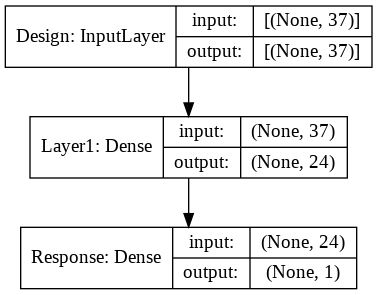

In [ ]:
keras.utils.plot_model(shallow_noofset, "shallow_model.png", show_shapes=True)

## Basic


In [ ]:
q0 = 37
q1 = 24
batch = 1024
epoch = 150

In [ ]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network')(layer1)
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential',
                        name = 'Response',
                        kernel_initializer = tf.keras.initializers.Constant(1.),
                        bias_initializer = 
                        tf.keras.initializers.Constant(0.))(addition)

shallow_base = keras.Model(
                      inputs = [Design, LogVol],
                      outputs = response)

shallow_base.compile(loss = poisson_deviance, optimizer = 'Adam')

In [ ]:
shallow_base.build(input_shape=(37,))
shallow_base.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 24)           912         Design[0][0]                     
__________________________________________________________________________________________________
Network (Dense)                 (None, 1)            25          Layer1[0][0]                     
__________________________________________________________________________________________________
LogVol (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
history = shallow_base.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose=2,
    epochs=epoch,
    batch_size = batch)


Epoch 1/150
596/596 - 1s - loss: 0.3449 - val_loss: 0.3325
Epoch 2/150
596/596 - 1s - loss: 0.3227 - val_loss: 0.3300
Epoch 3/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3291
Epoch 4/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3286
Epoch 5/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3281
Epoch 6/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3278
Epoch 7/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 8/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 9/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3279
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3277
Epoch 11/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3280
Epoch 12/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 13/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3282
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3280
Epoch 15/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo

In [ ]:
prediction(shallow_base)

Deviancia na trenovacej mnozine je:  0.3141031893251166
Deviancia na testovacej mnozine je:  0.32694657699170115


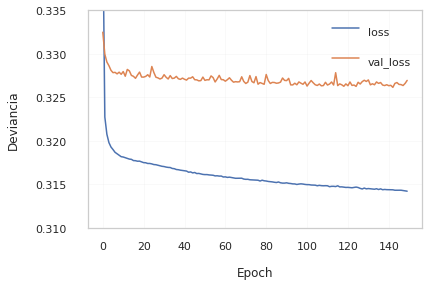

In [ ]:
plot_loss(history, yran=[0.31, 0.335], val = True)

## MLE init

In [ ]:
q0 = 37
g1 = 24
batch = 1024
epoch = 150

In [ ]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
                        bias_initializer =
                        tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer1)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
bias_initializer = tf.keras.initializers.Constant(0.))(addition)
shallow = keras.Model(
                      inputs = [Design, LogVol],
                      outputs = response
  )
shallow.compile(loss = poisson_deviance, optimizer = 'Adam') 

shallow.build(input_shape=(37,))
shallow.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 24)           912         Design[0][0]                     
__________________________________________________________________________________________________
Network (Dense)                 (None, 1)            25          Layer1[0][0]                     
__________________________________________________________________________________________________
LogVol (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

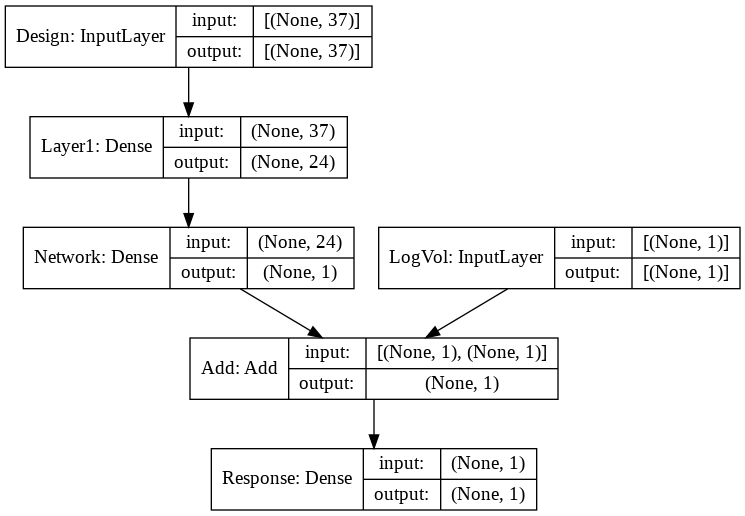

In [ ]:
keras.utils.plot_model(shallow, "shallow_model.png", show_shapes=True)

In [ ]:
history = shallow.fit(
    #x = [x, lv],
    #y = y,
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose=2,
    epochs=epoch,
    batch_size = batch)

Epoch 1/150
596/596 - 1s - loss: 0.3249 - val_loss: 0.3307
Epoch 2/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3281
Epoch 3/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3277
Epoch 4/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3277
Epoch 5/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 6/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 7/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3281
Epoch 8/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3280
Epoch 9/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3284
Epoch 11/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3275
Epoch 13/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 15/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo

NameError: ignored

In [ ]:
shallow.save('/content/drive/MyDrive/models/shallow_2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/shallow_2/assets


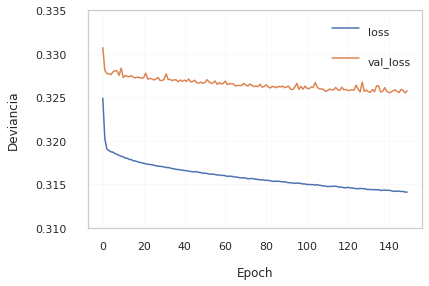

In [ ]:
plot_loss(history, yran=[0.31, 0.335], val = True)

In [ ]:
prediction(shallow)

Deviancia na trenovacej mnozine je:  0.3138057934738944
Deviancia na testovacej mnozine je:  0.3257563137677383


# Optimizer optimalization -  Shallow Net



In [ ]:
p = {'optimizer': [SGD, RMSprop, Nadam, Adam],
      'first_neuron': [16, 24, 32],
      'activation': ['relu', 'tanh'],
      'batch_size': [512, 1024, 2048],
      'lr': [0.002, 0.004, 0.01]
}
epoch = 150 # fix

In [ ]:
def shallow_optim(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'] , name = 'Layer1')(Design)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer1)
  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  shallow = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  shallow.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['lr'])) 

  #shallow.build(input_shape=(37,))
  #shallow.summary()
  history = shallow.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = epoch,
    batch_size = params['batch_size'])
  return history, shallow

In [ ]:
x_train.shape

(610212, 37)

In [ ]:
scan_shallow = talos.Scan(x=x_train, y=N_train, x_val= x_test, y_val=N_test , params=p, model=shallow_optim, experiment_name='shallow_optimalization_4', save_weights=True)

In [ ]:
scan_shallow.data.drop(['start', 'end'], axis = 1).sort_values(by = 'val_loss').head(10)

,duration,round_epochs,loss,val_loss,activation,batch_size,first_neuron,lr,optimizer
94,96.258291,150,0.306655,0.317758,relu,2048,24,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...
18,326.940323,150,0.307009,0.317813,relu,512,24,0.004,<class 'tensorflow.python.keras.optimizer_v2.n...
62,169.970877,150,0.305877,0.318015,relu,1024,32,0.002,<class 'tensorflow.python.keras.optimizer_v2.n...
58,171.068602,150,0.307153,0.318152,relu,1024,24,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...
14,328.005995,150,0.306752,0.318229,relu,512,24,0.002,<class 'tensorflow.python.keras.optimizer_v2.n...
15,251.503479,150,0.306951,0.318311,relu,512,24,0.002,<class 'tensorflow.python.keras.optimizer_v2.a...
46,171.082545,150,0.307701,0.318365,relu,1024,16,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...
6,328.519667,150,0.307721,0.318411,relu,512,16,0.004,<class 'tensorflow.python.keras.optimizer_v2.n...
54,170.958231,150,0.306575,0.318630,relu,1024,24,0.004,<class 'tensorflow.python.keras.optimizer_v2.n...
106,95.872369,150,0.306047,0.318719,relu,2048,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...


In [ ]:
scan_shallow.data.drop(['start', 'end'], axis = 1).sort_values(by = 'val_loss', ascending=False).head(10)

,duration,round_epochs,loss,val_loss,activation,batch_size,first_neuron,lr,optimizer
45,143.392827,150,0.312866,643404.437500,relu,1024,16,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
105,83.406837,150,0.312511,1306.336182,relu,2048,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
9,270.007346,150,0.319030,6.906536,relu,512,16,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
69,143.951133,150,0.313853,2.366367,relu,1024,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
17,270.815772,150,0.317807,1.946376,relu,512,24,0.004,<class 'tensorflow.python.keras.optimizer_v2.r...
57,143.689167,150,0.316633,0.397510,relu,1024,24,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
33,271.957649,150,0.319538,0.349928,relu,512,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
65,144.258424,150,0.315561,0.336734,relu,1024,32,0.004,<class 'tensorflow.python.keras.optimizer_v2.r...
72,76.151300,150,0.327484,0.336514,relu,2048,16,0.002,<class 'tensorflow.python.keras.optimizer_v2.g...
96,76.169772,150,0.326298,0.335305,relu,2048,32,0.002,<class 'tensorflow.python.keras.optimizer_v2.g...


In [ ]:
analyze_object = talos.Analyze(scan_shallow)


In [ ]:
analyze_object.low('val_loss')

0.31775766611099243

Text(14.875, 0.5, 'Validačná chyba')

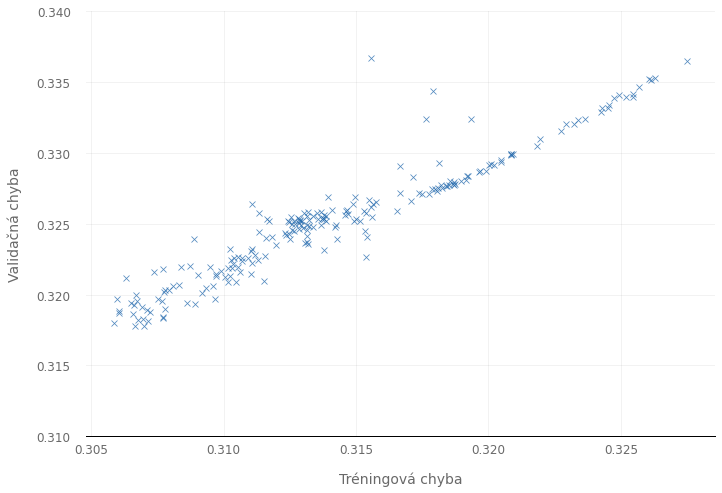

In [ ]:
analyze_object.plot_regs('loss', 'val_loss')
plt.ylim((0.31,0.34))
plt.xlabel('Tréningová chyba')
plt.ylabel('Validačná chyba')

Text(14.875, 0.5, 'Validačná chyba')

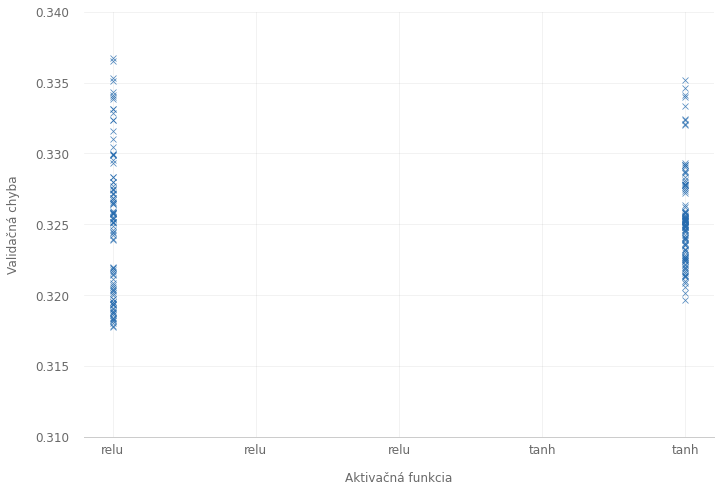

In [ ]:
analyze_object.plot_regs('activation', 'val_loss')
plt.ylim((0.31,0.34))
plt.xlabel('Aktivačná funkcia')
plt.ylabel('Validačná chyba')

Text(0, 0.5, 'Validačná chyba')

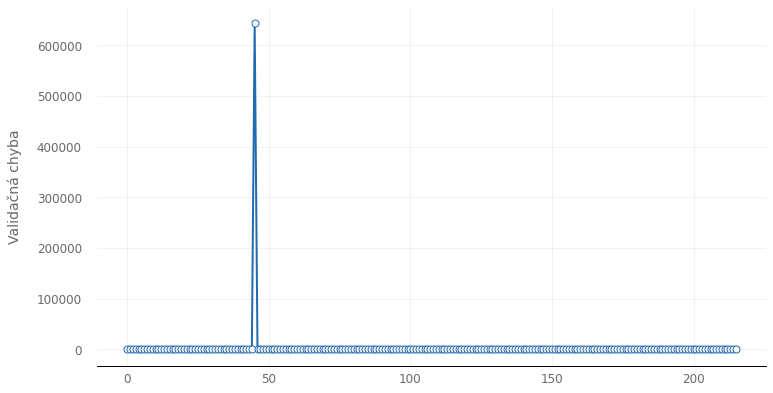

In [ ]:
analyze_object.plot_line('val_loss')
plt.ylabel('Validačná chyba')

Text(0.5, 24.4, 'Tréningová chyba')

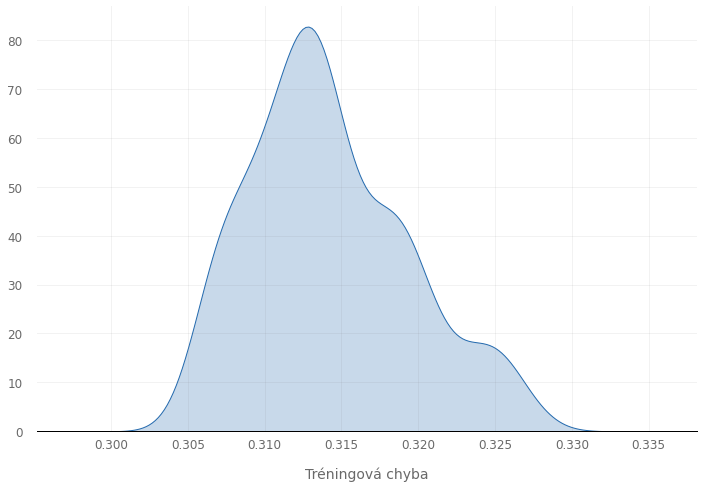

In [ ]:
analyze_object.plot_kde('loss')
plt.xlabel('Tréningová chyba')


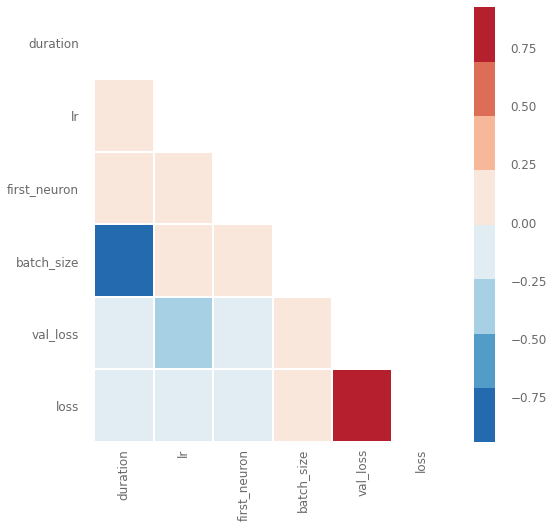

In [ ]:
analyze_object.plot_corr('val_loss', ['round_epochs'])


Text(0.5, 0, 'N')

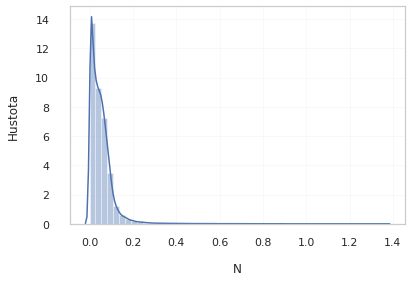

In [ ]:
#best model
best_shallow = scan_shallow.best_model(metric = 'val_loss', asc=True)
predictions = best_shallow.predict([x_test, lv_test]).flatten()
ax = sns.distplot(predictions)
#sns.histplot(predictions,  stat = 'probability')
sns.set_theme(style="whitegrid")
ax.set_ylabel("Hustota")
ax.set_xlabel("N")

In [ ]:
# mean freq
print(predictions.sum()/ v_test.sum())
# mean 
print(predictions.mean())

0.09778482008346892
0.05179085


In [ ]:
prediction(best_shallow)

Deviancia na trenovacej mnozine je:  0.3058743428619286
Deviancia na testovacej mnozine je:  0.31775812978656354


In [ ]:
talos.Deploy(scan_shallow, model_name = 'shalllow_scan', metric = 'val_loss', asc=True)

Deploy package shalllow_scan have been saved.


# Deep

## Scan of optimalization hyperparameters

In [ ]:
########################### Learning rate
##################################################
p_lr = {'activation':['tanh'],
          'optimizer': [Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [1024],
          'epochs': [150],
          'lr': [0.0001, 0.001, 0.05]}

In [ ]:
def deep_scan(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'], name = 'Layer1')(Design)
  layer2  = layers.Dense(params['second_neuron'], params['activation'],  name = 'Layer2')(layer1)
  layer3  = layers.Dense(params['third_neuron'], params['activation'],  name = 'Layer3')(layer2)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)

  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  deep = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  deep.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['optimizer'])) 

  history = deep.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = params['epochs'],
    batch_size = params['batch_size'])
  return history, deep

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_lr, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(3):
  batch = scanned_lr.round_history[i]['val_loss']
  batch_size[i] = batch
batch_size.columns = [0.0001, 0.001, 0.05]

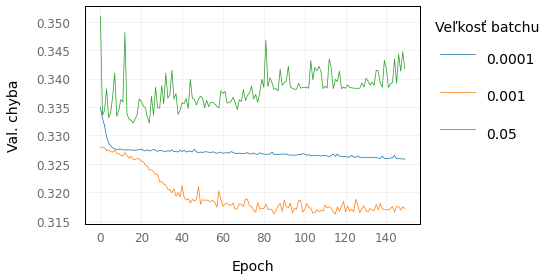

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Val. chyba')
ax.legend(bbox_to_anchor = (1.4,1), title="Veľkosť batchu")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
########################## Batch size
########################################################
p_deep = {'activation':['tanh'],
          'optimizer': [Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [256, 512, 1024, 2048, 4096, 10000, 200000],
          'epochs': [100],
          'lr': [ 0.001]}

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_deep, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(7):
  batch = scanned_lr.round_history[i]['loss']
  batch_size[i] = batch
batch_size.columns = [256, 512, 1024, 2048, 4096, 10000, 200000]


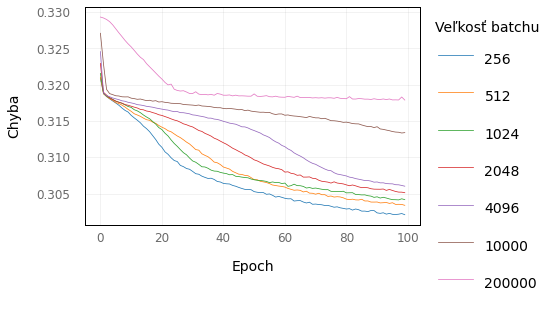

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.4,1), title="Veľkosť batchu")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(7):
  batch = scanned_lr.round_history[i]['val_loss']
  batch_size[i] = batch
batch_size.columns = [256, 512, 1024, 2048, 4096, 10000, 200000]

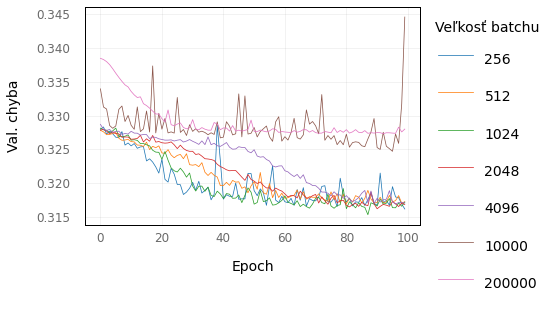

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Val. chyba')
ax.legend(bbox_to_anchor = (1.4,1), title="Veľkosť batchu")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
################# ACTIVATION
#############################################
p_act = {'activation':['tanh', 'relu'],
          'optimizer': [Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [1024],
          'epochs': [100],
          'lr': [ 0.001]}

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_act, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(2):
  batch = scanned_lr.round_history[i]['val_loss']
  batch_size[i] = batch
batch_size.columns = ['tanh', 'ReLu']

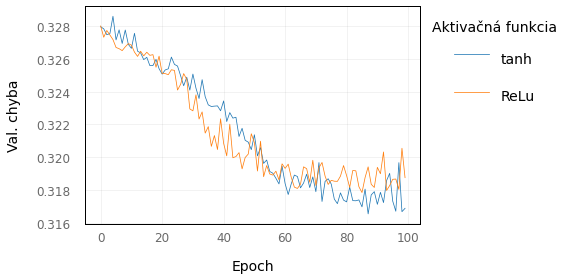

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Val. chyba')
ax.legend(bbox_to_anchor = (1.45,1), title="Aktivačná funkcia")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
################# optimalization algorithm
#############################################
p_opt= {'activation':['tanh'],
          'optimizer': [SGD, RMSprop, Adam, Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [1024],
          'epochs': [150]}

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_opt, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(4):
  batch = scanned_lr.round_history[i]['loss']
  batch_size[i] = batch
batch_size.columns = ['SGD', 'RMSprop','Adam', 'Nadam']

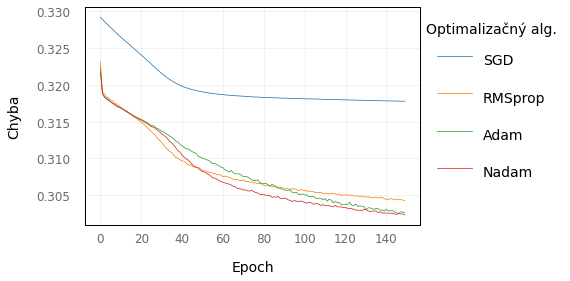

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.45,1), title="Optimalizačný alg.")
fig = ax.get_figure()
fig.savefig('batch_types.png')

## Scan of architercutre

In [ ]:
def deep_scan(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'], name = 'Layer1')(Design)
  layer2  = layers.Dense(params['second_neuron'], params['activation'],  name = 'Layer2')(layer1)
  layer3  = layers.Dense(params['third_neuron'], params['activation'],  name = 'Layer3')(layer2)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)

  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  deep = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  deep.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['lr'])) 

  history = deep.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = params['epochs'],
    batch_size = params['batch_size'])
  return history, deep

In [ ]:
########################### layers
##################################################
p_str = {'activation':['tanh'],
          'optimizer': [Nadam],
          'first_neuron': [64, 48, 40, 32, 24], 
          'second_neuron': [40, 32, 24, 16],   
          'third_neuron': [24, 16, 10],             
          'batch_size': [1024, 2048],
          'epochs': [150],
          'lr': [0.002]}

In [ ]:
scanned_layers = talos.Scan(x_train, N_train, model = deep_scan, params = p_str, experiment_name= 'testing_layers', x_val = x_test, y_val= N_test)

In [ ]:
analyze_deep = talos.Analyze(scanned_layers)

In [ ]:
scanned_layers.data.drop(['start', 'end', 'epochs','round_epochs', 'activation', 'lr'], axis = 1).sort_values(by = 'val_loss').head(10)

,duration,loss,val_loss,batch_size,first_neuron,optimizer,second_neuron,third_neuron
114,154.580538,0.301643,0.315730,2048,24,<class 'tensorflow.python.keras.optimizer_v2.n...,24,24
112,154.601599,0.301654,0.316199,2048,24,<class 'tensorflow.python.keras.optimizer_v2.n...,32,16
109,151.407556,0.300753,0.316927,2048,24,<class 'tensorflow.python.keras.optimizer_v2.n...,40,16
116,153.011465,0.302879,0.316927,2048,24,<class 'tensorflow.python.keras.optimizer_v2.n...,24,10
56,273.260674,0.301012,0.316946,1024,24,<class 'tensorflow.python.keras.optimizer_v2.n...,24,10
110,152.804097,0.301260,0.316976,2048,24,<class 'tensorflow.python.keras.optimizer_v2.n...,40,10
66,147.588226,0.298565,0.316997,2048,64,<class 'tensorflow.python.keras.optimizer_v2.n...,24,24
106,151.839063,0.303026,0.317025,2048,32,<class 'tensorflow.python.keras.optimizer_v2.n...,16,16
103,148.444797,0.300867,0.317029,2048,32,<class 'tensorflow.python.keras.optimizer_v2.n...,24,16
94,152.478592,0.302073,0.317111,2048,40,<class 'tensorflow.python.keras.optimizer_v2.n...,16,16


In [ ]:
df_val = pd.DataFrame()
df_val['best_val_loss'] = scanned_layers.round_history[114]['loss']
df_val['best_val_val_loss'] = scanned_layers.round_history[114]['val_loss']
df_val.columns = ['Tréningová chyba', 'Validačná chyba']

In [ ]:
scanned_layers.data.drop(['start', 'end', 'epochs','round_epochs', 'activation', 'lr'], axis = 1).sort_values(by = 'loss').head(10)

,duration,loss,val_loss,batch_size,first_neuron,optimizer,second_neuron,third_neuron
1,286.251574,0.292876,0.323856,1024,64,<class 'tensorflow.python.keras.optimizer_v2.n...,40,16
0,294.837796,0.293098,0.323242,1024,64,<class 'tensorflow.python.keras.optimizer_v2.n...,40,24
3,287.608987,0.293737,0.322046,1024,64,<class 'tensorflow.python.keras.optimizer_v2.n...,32,24
12,282.674445,0.294399,0.321446,1024,48,<class 'tensorflow.python.keras.optimizer_v2.n...,40,24
60,148.040660,0.294754,0.320790,2048,64,<class 'tensorflow.python.keras.optimizer_v2.n...,40,24
2,288.055216,0.294767,0.321252,1024,64,<class 'tensorflow.python.keras.optimizer_v2.n...,40,10
4,286.790710,0.294791,0.322791,1024,64,<class 'tensorflow.python.keras.optimizer_v2.n...,32,16
13,281.197824,0.295188,0.319625,1024,48,<class 'tensorflow.python.keras.optimizer_v2.n...,40,16
72,149.355346,0.295539,0.321841,2048,48,<class 'tensorflow.python.keras.optimizer_v2.n...,40,24
61,146.973080,0.295616,0.321231,2048,64,<class 'tensorflow.python.keras.optimizer_v2.n...,40,16


In [ ]:
df_los = pd.DataFrame()
df_los['best_val_loss'] = scanned_layers.round_history[1]['loss']
df_los['best_val_val_loss'] = scanned_layers.round_history[1]['val_loss']
df_los.columns = ['Tréningová chyba', 'Validačná chyba']

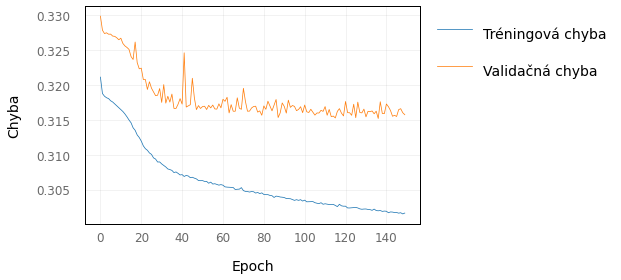

In [ ]:
ax = sns.lineplot(data=df_val, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.6,1))
plt.savefig('best_val.png',   bbox_inches = 'tight')

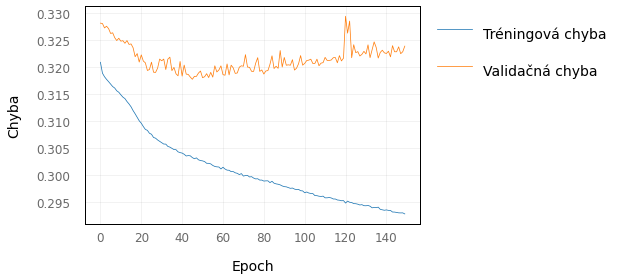

In [ ]:
ax = sns.lineplot(data=df_los, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.6,1))
plt.savefig('best_loss.png',   bbox_inches = 'tight')

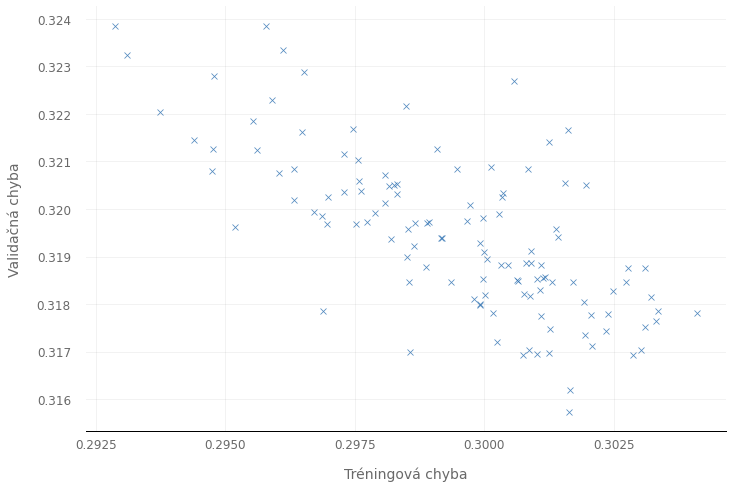

In [ ]:
analyze_deep.plot_regs('loss', 'val_loss')
plt.xlabel('Tréningová chyba')
plt.ylabel('Validačná chyba')
plt.savefig('val_to_losss.png',   bbox_inches = 'tight')

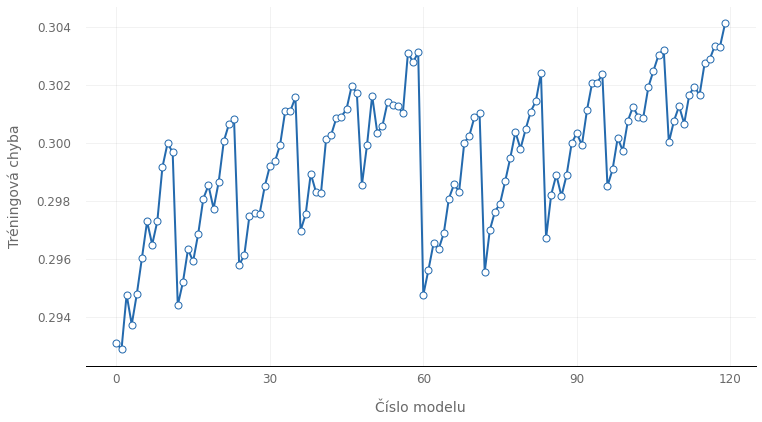

In [ ]:
analyze_deep.plot_line('loss')
plt.xlabel('Číslo modelu')
plt.ylabel('Tréningová chyba')
plt.savefig('no_loss.png',  bbox_inches = 'tight')

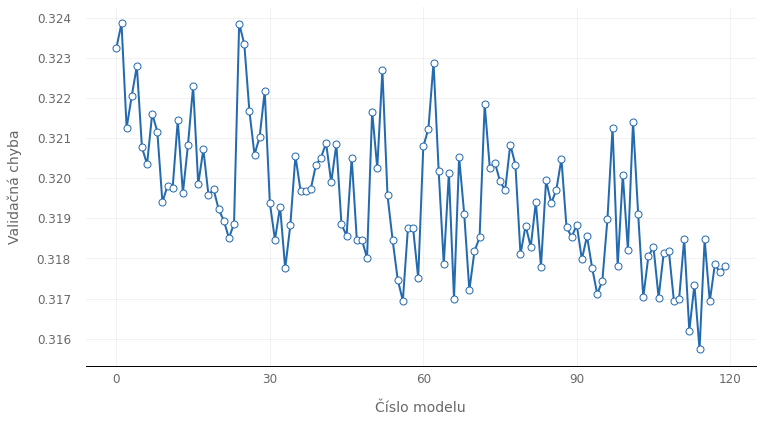

In [ ]:
analyze_deep.plot_line('val_loss')
plt.xlabel('Číslo modelu')
plt.ylabel('Validačná chyba')
plt.savefig('no_val.png',  bbox_inches = 'tight')

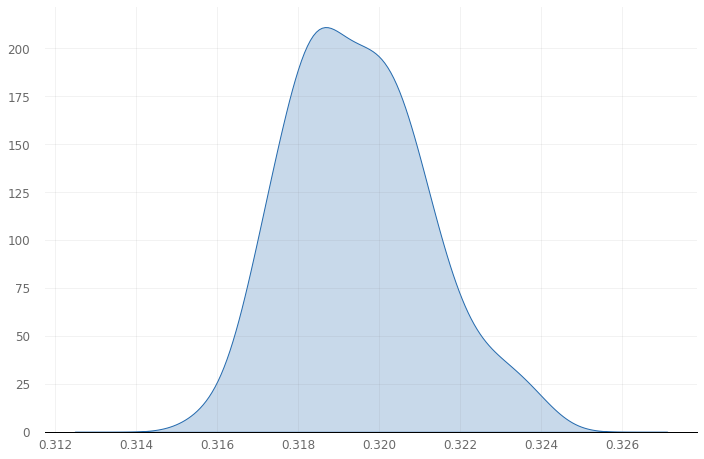

In [ ]:
analyze_deep.plot_kde('val_loss')

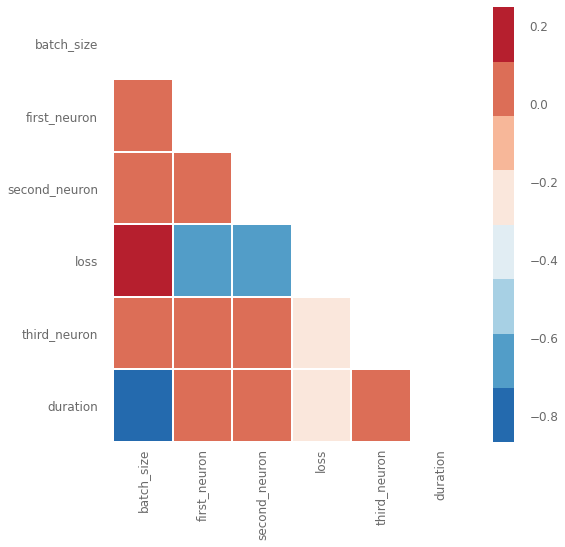

In [ ]:
analyze_deep.plot_corr('loss', ['start','end', 'lr', 'epochs', 'round_epochs', 'val_loss'])
plt.savefig('cor_loss.png', bbox_inches = 'tight')

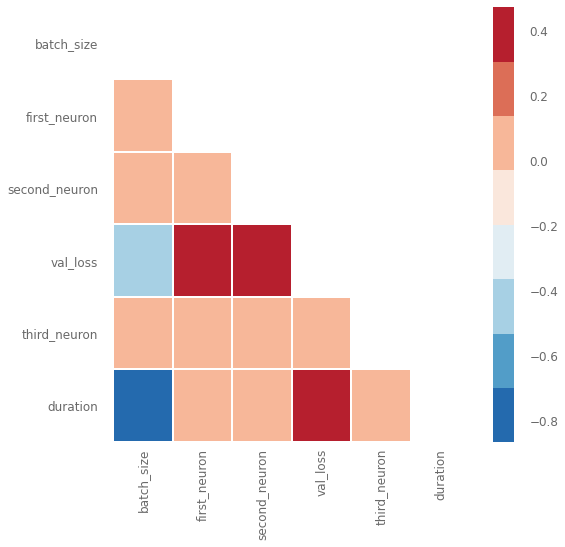

In [ ]:
analyze_deep.plot_corr('val_loss', ['start','end', 'lr', 'epochs', 'round_epochs', 'loss'])
plt.savefig('cor_val.png', bbox_inches = 'tight')

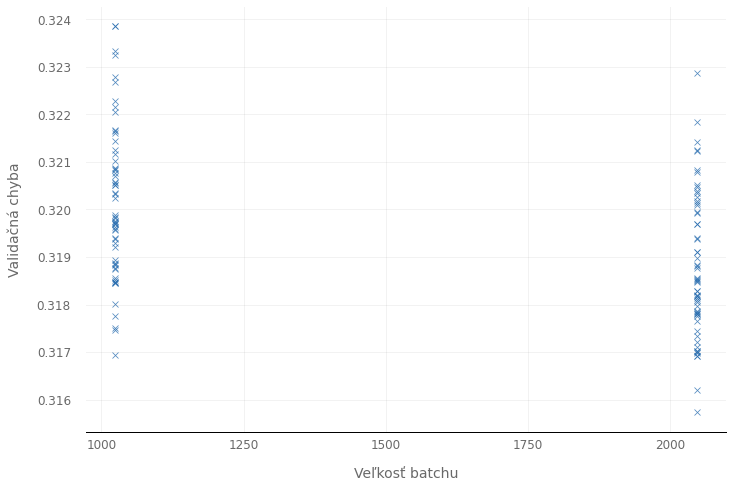

In [ ]:
analyze_deep.plot_regs('batch_size', 'val_loss')
plt.xlabel('Veľkosť batchu')
plt.ylabel('Validačná chyba')
plt.savefig('batch_loss.png',  bbox_inches = 'tight')

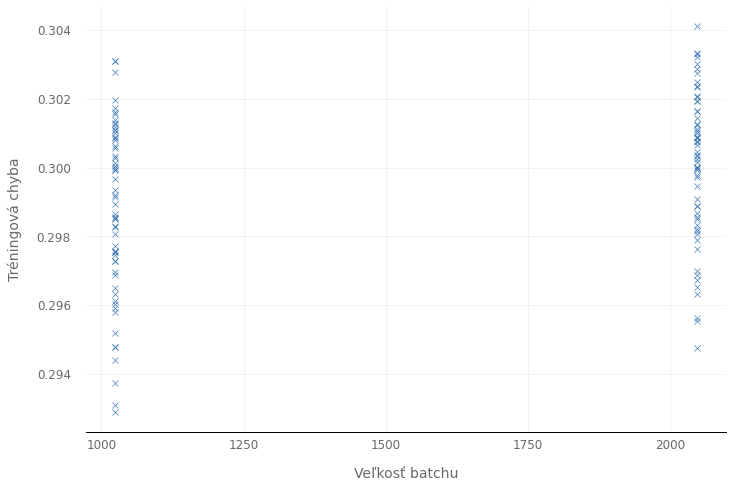

In [ ]:
analyze_deep.plot_regs('batch_size', 'loss')
plt.xlabel('Veľkosť batchu')
plt.ylabel('Tréningová chyba')
plt.savefig('batch_val.png',  bbox_inches = 'tight')

Text(0.5, 0, 'N')

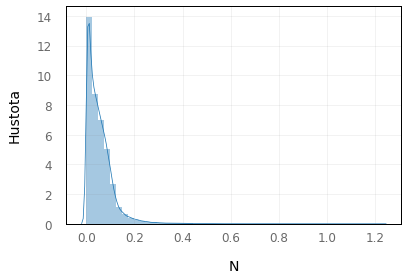

In [ ]:
#best model
deep_arch = scanned_layers.best_model(metric = 'val_loss', asc=True)
predictions = deep_arch.predict([x_test, lv_test]).flatten()
ax = sns.distplot(predictions)
#sns.histplot(predictions,  stat = 'probability')
sns.set_theme(style="whitegrid")
ax.set_ylabel("Hustota")
ax.set_xlabel("N")

In [ ]:
prediction(deep_arch)

Deviancia na trenovacej mnozine je:  0.30122074096098506
Deviancia na testovacej mnozine je:  0.31573080710551177
Priemerna frekvencia na testovacej mnozine:  0.10504229235113727


In [ ]:
analyze_deep.best_params('val_loss', ['loss'], ascending=True)[1]

array([150, 150, '05/07/21-165650', '05/07/21-165415', 2048, 0.002, 24,
       32, 'tanh', 16, 154.60159873962402,
       <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, 1],
      dtype=object)

In [ ]:
talos.Deploy(scanned_layers, model_name = 'deep_scan', metric = 'val_loss', asc=True)

Deploy package deep_scan have been saved.


## just picture of architercture

In [152]:
Design = tf.keras.Input(shape=(37,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(32, activation = 'tanh', name = 'Layer1')(Design)
layer2  = layers.Dense(24, activation= 'tanh',  name = 'Layer2')(layer1)
layer3  = layers.Dense(16, activation= 'tanh',  name = 'Layer3')(layer2)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
 bias_initializer = tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
 bias_initializer = tf.keras.initializers.Constant(0.))(addition)
deep = keras.Model(
    inputs = [Design,LogVol],
    outputs = response
)

deep.compile(loss = poisson_deviance, optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None))

deep.build(input_shape=(37,))
deep.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 32)           1216        Design[0][0]                     
__________________________________________________________________________________________________
Layer2 (Dense)                  (None, 24)           792         Layer1[0][0]                     
__________________________________________________________________________________________________
Layer3 (Dense)                  (None, 16)           400         Layer2[0][0]                     
____________________________________________________________________________________________

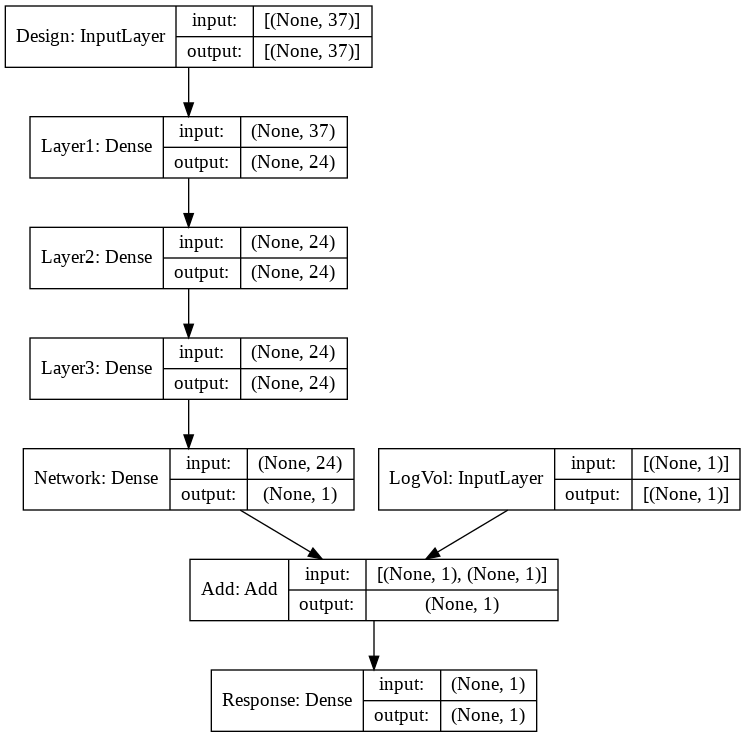

In [ ]:
keras.utils.plot_model(deep, "deep_3.png", show_shapes=True, )
